# Synthetic Garbage Detection Data Generator

This notebook creates synthetic images for training garbage detection models on roads.
The approach generates:
- Neutral backgrounds (yellow ground, gray roads, green vegetation)
- Bright garbage objects placed realistically
- Shrubs with partial occlusion of objects
- Proper lighting and shadows

## Key Learning Objectives:
1. Understanding procedural texture generation
2. Object placement with physics-aware positioning  
3. Alpha blending for realistic occlusion
4. Automatic annotation generation

In [ ]:
! ls "../synth-v2-until-113/images"

0.jpg    2122.jpg 3248.jpg 4373.jpg 5499.jpg 6623.jpg 7749.jpg 8874.jpg
1.jpg    2123.jpg 3249.jpg 4374.jpg 55.jpg   6624.jpg 775.jpg  8875.jpg
10.jpg   2124.jpg 325.jpg  4375.jpg 550.jpg  6625.jpg 7750.jpg 8876.jpg
100.jpg  2125.jpg 3250.jpg 4376.jpg 5500.jpg 6626.jpg 7751.jpg 8877.jpg
1000.jpg 2126.jpg 3251.jpg 4377.jpg 5501.jpg 6627.jpg 7752.jpg 8878.jpg
1001.jpg 2127.jpg 3252.jpg 4378.jpg 5502.jpg 6628.jpg 7753.jpg 8879.jpg
1002.jpg 2128.jpg 3253.jpg 4379.jpg 5503.jpg 6629.jpg 7754.jpg 888.jpg
1003.jpg 2129.jpg 3254.jpg 438.jpg  5504.jpg 663.jpg  7755.jpg 8880.jpg
1004.jpg 213.jpg  3255.jpg 4380.jpg 5505.jpg 6630.jpg 7756.jpg 8881.jpg
1005.jpg 2130.jpg 3256.jpg 4381.jpg 5506.jpg 6631.jpg 7757.jpg 8882.jpg
1006.jpg 2131.jpg 3257.jpg 4382.jpg 5507.jpg 6632.jpg 7758.jpg 8883.jpg
1007.jpg 2132.jpg 3258.jpg 4383.jpg 5508.jpg 6633.jpg 7759.jpg 8884.jpg
1008.jpg 2133.jpg 3259.jpg 4384.jpg 5509.jpg 6634.jpg 776.jpg  8885.jpg
1009.jpg 2134.jpg 326.jpg  4385.jpg 551.jpg  6635.jpg 7760.jpg 88

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random
from typing import List, Tuple, Dict
from dataclasses import dataclass
import json
from pathlib import Path

## Configuration and Data Structures

Define the core parameters and data structures for our synthetic data generation.
These parameters control the appearance and behavior of our generated scenes.

In [2]:
@dataclass
class GenerationConfig:
    """Configuration for synthetic data generation"""
    # Image dimensions
    img_width: int = 800
    img_height: int = 600
    
    # Background colors (BGR format for OpenCV)
    road_color_base: Tuple[int, int, int] = (80, 80, 80)  # Dark gray
    ground_color_base: Tuple[int, int, int] = (60, 140, 180)  # Yellow-brown
    vegetation_color_base: Tuple[int, int, int] = (50, 120, 50)  # Green
    
    # Color variation ranges (±)
    color_variation: int = 30
    
    # Object properties
    min_objects: int = 3
    max_objects: int = 8
    object_colors: List[Tuple[int, int, int]] = None
    min_object_size: int = 20
    max_object_size: int = 80
    
    # Shrub properties
    min_shrubs: int = 2
    max_shrubs: int = 5
    shrub_opacity_range: Tuple[float, float] = (0.3, 0.8)
    
    # Noise and texture
    noise_intensity: float = 0.15
    
    def __post_init__(self):
        if self.object_colors is None:
            # Bright colors that stand out against neutral backgrounds
            self.object_colors = [
                (255, 255, 255),  # White
                (0, 200, 255),    # Orange  
                (0, 255, 255),    # Yellow
                (255, 100, 100),  # Light blue
                (200, 200, 255),  # Pink
                (100, 255, 100),  # Light green
            ]

## Procedural Background Generation

Create neutral backgrounds with realistic texture variation using Perlin-like noise.
This simulates natural color variation in roads, ground, and vegetation.

In [3]:
class BackgroundGenerator:
    """Generates procedural backgrounds with realistic texture variation"""
    
    @staticmethod
    def generate_perlin_noise(width: int, height: int, scale: float = 0.1) -> np.ndarray:
        """
        Generate Perlin-like noise for texture variation
        
        Args:
            width, height: Dimensions of noise map
            scale: Controls frequency of noise (smaller = more detailed)
        
        Returns:
            2D array with values between -1 and 1
        """
        # Create coordinate grids
        x = np.linspace(0, scale * width, width)
        y = np.linspace(0, scale * height, height)
        X, Y = np.meshgrid(x, y)
        
        # Generate multiple octaves of noise for more natural appearance
        noise = np.zeros((height, width))
        
        # Multiple octaves with decreasing amplitude and increasing frequency
        for octave in range(4):
            freq = 2 ** octave
            amp = 1 / (2 ** octave)
            
            # Simple noise function using sine waves
            noise += amp * (np.sin(freq * X) * np.cos(freq * Y) + 
                           np.sin(freq * X * 1.3) * np.cos(freq * Y * 0.7))
        
        # Normalize to [-1, 1]
        return noise / np.max(np.abs(noise))
    
    @staticmethod
    def create_background_regions(width: int, height: int) -> np.ndarray:
        """
        Create regions for road, ground, and vegetation
        
        Returns:
            2D array where 0=road, 1=ground, 2=vegetation
        """
        regions = np.zeros((height, width), dtype=np.uint8)
        
        # Create horizontal bands with some variation
        road_y_start = int(height * 0.4)
        road_y_end = int(height * 0.7)
        
        # Add some curved variation to road boundaries
        x_coords = np.arange(width)
        road_top_variation = 20 * np.sin(x_coords * 0.01)
        road_bottom_variation = 15 * np.sin(x_coords * 0.008 + 1)
        
        for x in range(width):
            road_top = int(road_y_start + road_top_variation[x])
            road_bottom = int(road_y_end + road_bottom_variation[x])
            
            # Ground (top section)
            regions[:road_top, x] = 1
            # Road (middle section)  
            regions[road_top:road_bottom, x] = 0
            # Vegetation (bottom section)
            regions[road_bottom:, x] = 2
            
        return regions
    
    def generate_background(self, config: GenerationConfig) -> np.ndarray:
        """
        Generate a complete background image with regions and textures
        """
        # Create region map
        regions = self.create_background_regions(config.img_width, config.img_height)
        
        # Generate noise for texture variation
        noise = self.generate_perlin_noise(
            config.img_width, config.img_height, scale=0.02
        )
        
        # Initialize background image
        background = np.zeros((config.img_height, config.img_width, 3), dtype=np.uint8)
        
        # Apply base colors with noise variation
        colors = [config.road_color_base, config.ground_color_base, config.vegetation_color_base]
        
        for region_id in range(3):
            mask = regions == region_id
            base_color = np.array(colors[region_id])
            
            # Apply noise variation to each channel
            for channel in range(3):
                color_noise = noise * config.color_variation * config.noise_intensity
                varied_color = base_color[channel] + color_noise
                varied_color = np.clip(varied_color, 0, 255)
                background[mask, channel] = varied_color[mask]
        
        return background, regions

## Garbage Object Generation

Create bright garbage objects with various shapes and realistic placement.
Objects are designed to stand out against neutral backgrounds.

In [4]:
@dataclass
class GarbageObject:
    """Represents a single garbage object with position and properties"""
    x: int
    y: int
    width: int  
    height: int
    color: Tuple[int, int, int]
    shape: str  # 'rectangle', 'ellipse', 'polygon'
    rotation: float = 0.0
    opacity: float = 1.0

class GarbageObjectGenerator:
    """Generates realistic garbage objects"""
    
    @staticmethod
    def generate_object_shape(obj: GarbageObject, background: np.ndarray) -> np.ndarray:
        """
        Generate a single object shape and blend it with background
        
        Args:
            obj: GarbageObject with properties
            background: Background image to draw on
            
        Returns:
            Image with object drawn
        """
        img = background.copy()
        
        if obj.shape == 'rectangle':
            # Simple rectangle
            cv2.rectangle(img, 
                         (obj.x, obj.y), 
                         (obj.x + obj.width, obj.y + obj.height),
                         obj.color, -1)
                         
        elif obj.shape == 'ellipse':
            # Elliptical object (bottles, cans, etc.)
            center = (obj.x + obj.width//2, obj.y + obj.height//2)
            axes = (obj.width//2, obj.height//2)
            cv2.ellipse(img, center, axes, obj.rotation, 0, 360, obj.color, -1)
            
        elif obj.shape == 'polygon':
            # Irregular polygon (plastic bags, wrappers)
            center_x, center_y = obj.x + obj.width//2, obj.y + obj.height//2
            points = []
            num_points = random.randint(5, 8)
            
            for i in range(num_points):
                angle = 2 * np.pi * i / num_points + obj.rotation
                # Add some randomness to make irregular
                radius_x = obj.width//2 * (0.8 + 0.4 * random.random())
                radius_y = obj.height//2 * (0.8 + 0.4 * random.random())
                
                x = int(center_x + radius_x * np.cos(angle))
                y = int(center_y + radius_y * np.sin(angle))
                points.append([x, y])
                
            pts = np.array(points, dtype=np.int32)
            cv2.fillPoly(img, [pts], obj.color)
        
        return img
    
    def generate_objects(self, config: GenerationConfig, regions: np.ndarray) -> List[GarbageObject]:
        """
        Generate multiple garbage objects with realistic placement
        """
        objects = []
        num_objects = random.randint(config.min_objects, config.max_objects)
        
        for _ in range(num_objects):
            # Random size within bounds
            width = random.randint(config.min_object_size, config.max_object_size)
            height = random.randint(config.min_object_size, config.max_object_size)
            
            # Find valid placement (prefer road and ground regions)
            attempts = 50
            for _ in range(attempts):
                x = random.randint(0, config.img_width - width)
                y = random.randint(0, config.img_height - height)
                
                # Check if placement is mostly on road (0) or ground (1) regions
                region_sample = regions[y:y+height, x:x+width]
                if region_sample.size > 0:
                    road_ground_ratio = np.sum((region_sample <= 1)) / region_sample.size
                    if road_ground_ratio > 0.7:  # At least 70% on road/ground
                        break
            
            # Random properties
            color = random.choice(config.object_colors)
            shape = random.choice(['rectangle', 'ellipse', 'polygon'])
            rotation = random.uniform(0, 360)
            
            obj = GarbageObject(x, y, width, height, color, shape, rotation)
            objects.append(obj)
            
        return objects

## Vegetation and Occlusion System

Create shrubs and vegetation that can partially occlude garbage objects,
making detection more challenging and realistic.

In [5]:
class VegetationGenerator:
    """Generates vegetation with alpha blending for realistic occlusion"""
    
    @staticmethod
    def create_shrub_mask(center_x: int, center_y: int, radius: int, 
                         img_shape: Tuple[int, int]) -> np.ndarray:
        """
        Create an organic shrub shape using multiple overlapping circles
        
        Returns:
            Alpha mask where 1.0 = fully opaque vegetation, 0.0 = transparent
        """
        height, width = img_shape[:2]
        mask = np.zeros((height, width), dtype=np.float32)
        
        # Create shrub with multiple overlapping circles for organic look
        num_circles = random.randint(8, 15)
        
        for _ in range(num_circles):
            # Offset from center with some randomness
            offset_x = random.randint(-radius//2, radius//2)
            offset_y = random.randint(-radius//2, radius//2)
            circle_x = max(0, min(width-1, center_x + offset_x))
            circle_y = max(0, min(height-1, center_y + offset_y))
            
            # Variable circle sizes
            circle_radius = random.randint(radius//4, radius//2)
            
            # Draw circle on mask
            cv2.circle(mask, (circle_x, circle_y), circle_radius, 1.0, -1)
        
        # Add some noise for more organic edges
        noise = np.random.random((height, width)) * 0.3
        mask = np.clip(mask + noise, 0, 1)
        
        # Smooth the edges
        mask = cv2.GaussianBlur(mask, (5, 5), 2)
        
        return mask
    
    def add_vegetation_layer(self, image: np.ndarray, regions: np.ndarray, 
                           config: GenerationConfig) -> np.ndarray:
        """
        Add vegetation layer that can partially occlude objects
        """
        result = image.copy()
        height, width = image.shape[:2]
        
        num_shrubs = random.randint(config.min_shrubs, config.max_shrubs)
        
        for _ in range(num_shrubs):
            # Place shrubs primarily in vegetation regions but allow some overlap
            vegetation_mask = regions == 2
            if not np.any(vegetation_mask):
                continue
                
            # Find vegetation pixels for placement
            veg_coords = np.where(vegetation_mask)
            if len(veg_coords[0]) == 0:
                continue
                
            # Random placement in vegetation area
            idx = random.randint(0, len(veg_coords[0]) - 1)
            center_y, center_x = veg_coords[0][idx], veg_coords[1][idx]
            
            # Random shrub size
            radius = random.randint(30, 80)
            
            # Create shrub mask
            shrub_mask = self.create_shrub_mask(center_x, center_y, radius, (height, width))
            
            # Vegetation color with variation
            base_color = np.array(config.vegetation_color_base)
            color_var = random.randint(-config.color_variation, config.color_variation)
            shrub_color = np.clip(base_color + color_var, 0, 255)
            
            # Alpha blending opacity
            opacity = random.uniform(*config.shrub_opacity_range)
            
            # Apply vegetation overlay with alpha blending
            for c in range(3):
                result[:, :, c] = (result[:, :, c] * (1 - shrub_mask * opacity) + 
                                 shrub_color[c] * shrub_mask * opacity)
        
        return result.astype(np.uint8)

## Complete Scene Generator

Combines all components to generate complete synthetic scenes with annotations.

In [6]:
class SyntheticSceneGenerator:
    """Main class that orchestrates the generation of complete synthetic scenes"""
    
    def __init__(self, config: GenerationConfig):
        self.config = config
        self.bg_generator = BackgroundGenerator()
        self.obj_generator = GarbageObjectGenerator()
        self.veg_generator = VegetationGenerator()
    
    def generate_scene(self) -> Dict:
        """
        Generate a complete synthetic scene with image and annotations
        
        Returns:
            Dictionary containing:
            - 'image': Generated image (numpy array)
            - 'objects': List of object annotations
            - 'metadata': Scene generation metadata
        """
        # Step 1: Generate background
        background, regions = self.bg_generator.generate_background(self.config)
        
        # Step 2: Generate objects
        objects = self.obj_generator.generate_objects(self.config, regions)
        
        # Step 3: Draw objects on background
        scene = background.copy()
        for obj in objects:
            scene = self.obj_generator.generate_object_shape(obj, scene)
        
        # Step 4: Add vegetation layer (partial occlusion)
        final_scene = self.veg_generator.add_vegetation_layer(scene, regions, self.config)
        
        # Step 5: Create annotations
        annotations = []
        for i, obj in enumerate(objects):
            annotations.append({
                'id': i,
                'bbox': [obj.x, obj.y, obj.width, obj.height],
                'category': 'garbage',
                'color': obj.color,
                'shape': obj.shape,
                'area': obj.width * obj.height
            })
        
        return {
            'image': final_scene,
            'objects': annotations,
            'metadata': {
                'num_objects': len(objects),
                'image_size': (self.config.img_width, self.config.img_height),
                'generation_config': self.config.__dict__
            }
        }

## Visualization and Analysis Tools

Tools for visualizing generated data and understanding the generation process.

In [7]:
def visualize_scene(scene_data: Dict, show_annotations: bool = True, figsize: Tuple[int, int] = (12, 8)):
    """
    Visualize a generated scene with optional bounding box annotations
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Show original image
    image = scene_data['image']
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Generated Scene')
    axes[0].axis('off')
    
    # Show image with annotations
    annotated = image.copy()
    if show_annotations:
        for obj in scene_data['objects']:
            x, y, w, h = obj['bbox']
            cv2.rectangle(annotated, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(annotated, f"ID:{obj['id']}", (x, y-5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    axes[1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Scene with Annotations')
    axes[1].axis('off')
    
    # Print metadata
    print(f"Generated {scene_data['metadata']['num_objects']} objects")
    print("Object details:")
    for obj in scene_data['objects']:
        print(f"  ID {obj['id']}: {obj['shape']} at ({obj['bbox'][0]}, {obj['bbox'][1]}) "
              f"size {obj['bbox'][2]}x{obj['bbox'][3]}")
    
    plt.tight_layout()
    plt.show()

def analyze_color_distribution(scene_data: Dict):
    """
    Analyze color distribution in the generated scene
    """
    image = scene_data['image']
    
    # Convert to RGB for analysis
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Plot color histograms
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    colors = ['Red', 'Green', 'Blue']
    
    for i, color in enumerate(colors):
        axes[i].hist(image_rgb[:, :, i].flatten(), bins=50, alpha=0.7, color=color.lower())
        axes[i].set_title(f'{color} Channel Distribution')
        axes[i].set_xlabel('Pixel Value')
        axes[i].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

## Experimentation Interface

Easy-to-use functions for experimenting with different parameters and settings.

In [8]:
def experiment_with_parameters():
    """
    Interactive experimentation function to understand parameter effects
    """
    print("=== Synthetic Garbage Data Generation Experiment ===\n")
    
    # Base configuration
    base_config = GenerationConfig()
    
    print("1. Testing base configuration...")
    generator = SyntheticSceneGenerator(base_config)
    scene1 = generator.generate_scene()
    visualize_scene(scene1)
    
    print("\n2. Testing with more objects and different colors...")
    config2 = GenerationConfig(
        min_objects=6,
        max_objects=12,
        object_colors=[
            (255, 255, 255),  # White
            (0, 0, 255),      # Red
            (0, 255, 0),      # Green
            (255, 255, 0),    # Cyan
        ]
    )
    generator2 = SyntheticSceneGenerator(config2)
    scene2 = generator2.generate_scene()
    visualize_scene(scene2)
    
    print("\n3. Testing with larger objects and more shrubs...")
    config3 = GenerationConfig(
        min_object_size=40,
        max_object_size=120,
        min_shrubs=4,
        max_shrubs=8,
        shrub_opacity_range=(0.4, 0.9)
    )
    generator3 = SyntheticSceneGenerator(config3)
    scene3 = generator3.generate_scene()
    visualize_scene(scene3)
    
    return [scene1, scene2, scene3]

def batch_generate(config: GenerationConfig, num_images: int = 10, 
                  save_path: str = None) -> List[Dict]:
    """
    Generate multiple images for dataset creation
    
    Args:
        config: Generation configuration
        num_images: Number of images to generate
        save_path: Optional path to save images and annotations
        
    Returns:
        List of scene dictionaries
    """
    generator = SyntheticSceneGenerator(config)
    scenes = []
    
    print(f"Generating {num_images} synthetic scenes...")
    
    for i in range(num_images):
        print(f"Generating image {i+1}/{num_images}...", end='\r')
        scene = generator.generate_scene()
        scenes.append(scene)
        
        # Optionally save to disk
        if save_path:
            save_dir = Path(save_path)
            save_dir.mkdir(exist_ok=True)
            
            # Save image
            img_path = save_dir / f"image_{i:04d}.jpg"
            cv2.imwrite(str(img_path), scene['image'])
            
            # Save annotations
            ann_path = save_dir / f"annotations_{i:04d}.json"
            with open(ann_path, 'w') as f:
                json.dump({
                    'objects': scene['objects'],
                    'metadata': scene['metadata']
                }, f, indent=2)
    
    print(f"\nGenerated {num_images} scenes successfully!")
    return scenes

## Example Usage and Experiments

Run this section to see the generator in action and experiment with parameters.

Running parameter experiments...
=== Synthetic Garbage Data Generation Experiment ===

1. Testing base configuration...
Generated 8 objects
Object details:
  ID 0: polygon at (62, 172) size 30x20
  ID 1: rectangle at (511, 12) size 46x49
  ID 2: polygon at (36, 335) size 72x59
  ID 3: rectangle at (564, 216) size 40x50
  ID 4: ellipse at (673, 384) size 60x38
  ID 5: rectangle at (445, 386) size 56x26
  ID 6: ellipse at (211, 60) size 72x42
  ID 7: polygon at (536, 153) size 65x32


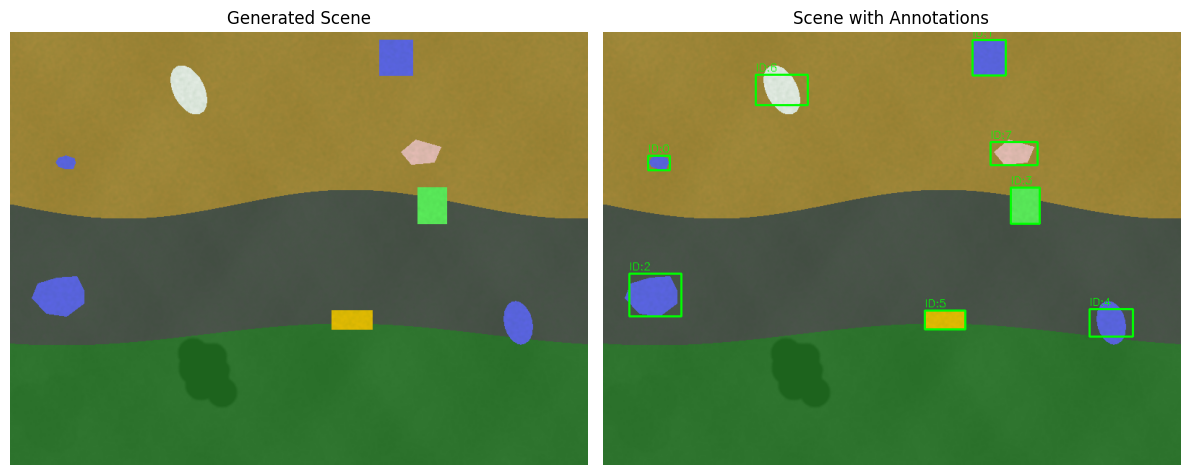


2. Testing with more objects and different colors...
Generated 6 objects
Object details:
  ID 0: polygon at (103, 256) size 64x49
  ID 1: ellipse at (660, 45) size 33x45
  ID 2: polygon at (246, 149) size 59x53
  ID 3: rectangle at (121, 371) size 28x20
  ID 4: rectangle at (545, 210) size 74x25
  ID 5: rectangle at (255, 8) size 67x56


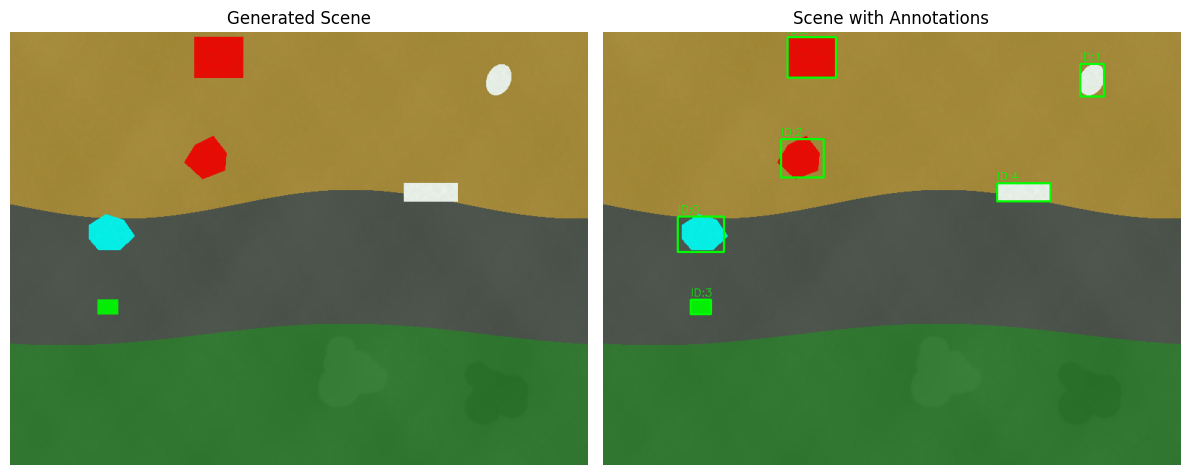


3. Testing with larger objects and more shrubs...
Generated 4 objects
Object details:
  ID 0: rectangle at (559, 64) size 102x82
  ID 1: rectangle at (229, 351) size 99x83
  ID 2: polygon at (698, 113) size 69x99
  ID 3: polygon at (91, 9) size 50x91


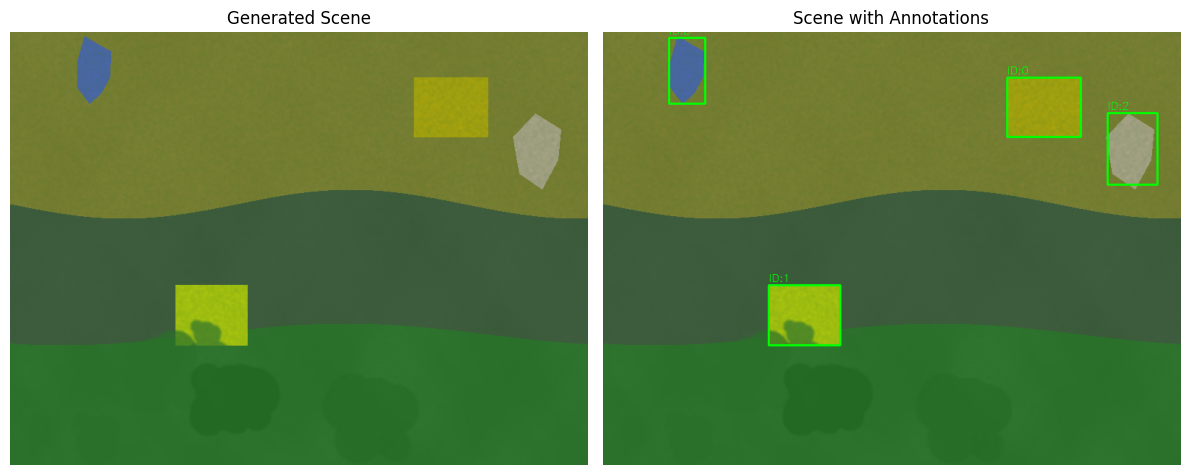


Analyzing color distribution...


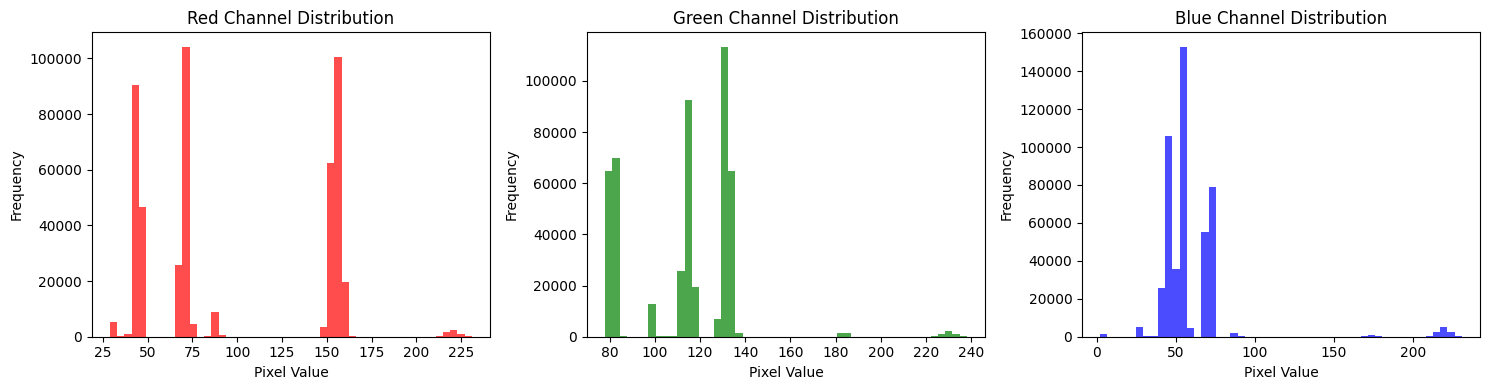


Generating batch of images...
Generating 5 synthetic scenes...
Generating image 5/5...
Generated 5 scenes successfully!

Batch Statistics:
Average objects per image: 6.40
Object count range: 4 - 8


In [9]:
if __name__ == "__main__":
    # Run experiments to understand the system
    print("Running parameter experiments...")
    experiment_scenes = experiment_with_parameters()
    
    # Analyze color distribution of first scene
    print("\nAnalyzing color distribution...")
    analyze_color_distribution(experiment_scenes[0])
    
    # Generate a small batch for dataset creation
    print("\nGenerating batch of images...")
    config = GenerationConfig(min_objects=4, max_objects=8)
    batch_scenes = batch_generate(config, num_images=5)
    
    # Show statistics
    object_counts = [len(scene['objects']) for scene in batch_scenes]
    print(f"\nBatch Statistics:")
    print(f"Average objects per image: {np.mean(object_counts):.2f}")
    print(f"Object count range: {min(object_counts)} - {max(object_counts)}")

In [43]:
def cv2_plot(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Gaussian = cv2.GaussianBlur(resized_image, (15, 15), 0)  

In [25]:
images = list((Path.home() / "Desktop/personal/roads/mapillary_downloader/data/samples/ahmedabad/images").glob("*.jpg"))

In [39]:
cands = [6, 7, 8]

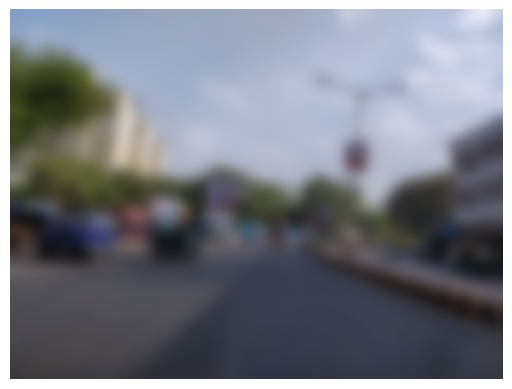

In [51]:
cv2_plot(cv2.GaussianBlur(cv2.imread(images[7]), (91, 91), 0))

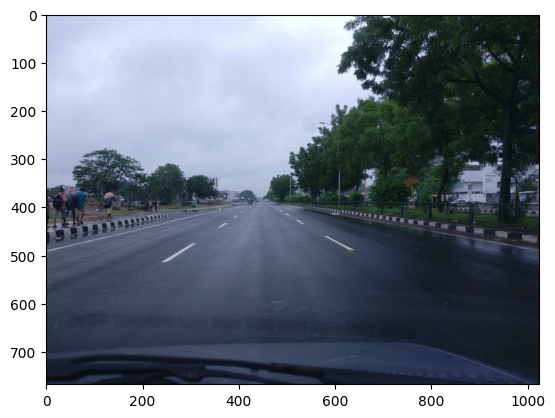

In [38]:
plt.imshow(plt.imread(images[6]))

In [ ]:
! ls ~/Desktop/personal/roads/mapillary_downloader/data/samples/ahmedabad/images/1027217829154608

1027217829154608.jpg 1919969858503114.jpg 504028619172839.jpg
1040370214497630.jpg 193730649256073.jpg  505041967346904.jpg
1043379220718323.jpg 1939961136414992.jpg 505829117111602.jpg
1054906889373176.jpg 2000160680427378.jpg 511775745111788.jpg
1055807856084827.jpg 211475543786311.jpg  512242458371379.jpg
1067078491429281.jpg 2434275446770998.jpg 524990043499759.jpg
1076276384139432.jpg 2501438846669126.jpg 541683208557587.jpg
1081421333341387.jpg 252987033288051.jpg  543774761541562.jpg
1093238695720080.jpg 260787972456359.jpg  550110267468707.jpg
1111526756008023.jpg 272196584589826.jpg  555344996958159.jpg
1147975379007425.jpg 2838204423024599.jpg 558626653268014.jpg
1149628262116255.jpg 287642849698135.jpg  558810179829085.jpg
1176392586131609.jpg 304047874589493.jpg  567397978958140.jpg
1184436452661136.jpg 310530147101227.jpg  572539640382583.jpg
1204543610795649.jpg 314181903484044.jpg  745788807645363.jpg
1233090944476578.jpg 321874412621996.jpg  759896744701119.jpg
12499181